# RBF-AR methods comparison

This notebook generates a synthetic time series, constructs a design matrix using one of the two approaches, runs either the OLS or SVD-based optimizer, and visualizes the reconstruction performance.


In [55]:
# Imports and configuration
import importlib.util
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import torch
import matplotlib.pyplot as plt

# Resolve paths relative to the workspace folder (current working directory)
root = Path.cwd()

# Design matrix module
_dm_path = root / "design_matrix_constructor.py"
spec_dm = importlib.util.spec_from_file_location("design_matrix_constructor", str(_dm_path))
dm = importlib.util.module_from_spec(spec_dm)
assert spec_dm and spec_dm.loader
spec_dm.loader.exec_module(dm)

# OLS optimizer
_ols_path = root / "ols-optimizer.py"
spec_ols = importlib.util.spec_from_file_location("ols_optimizer", str(_ols_path))
ols_mod = importlib.util.module_from_spec(spec_ols)
assert spec_ols and spec_ols.loader
spec_ols.loader.exec_module(ols_mod)

# SVD optimizer
_svd_path = root / "svd-baed-optimizer.py"
spec_svd = importlib.util.spec_from_file_location("svd_optimizer", str(_svd_path))
svd_mod = importlib.util.module_from_spec(spec_svd)
assert spec_svd and spec_svd.loader
spec_svd.loader.exec_module(svd_mod)

@dataclass
class Config:
    approach: str = "no_pretraining"  # "no_pretraining" | "local_pretraining"
    optimizer: str = "ols"             # "ols" | "svd"
    l: int = 500                        # samples
    n: int = 4                          # AR order (features per row)
    m: int = 120                        # number of candidate centres
    noise: float = 0.05
    sigma: float | None = None          # None -> heuristic
    rbf: str = "gaussian"              # "gaussian" | "laplacian"
    ridge: float = 1e-6                 # only for local_pretraining

cfg = Config()

rbf_map = {
    "gaussian": dm.RadialBasisFunction.GAUSSIAN,
    "laplacian": dm.RadialBasisFunction.LAPLACIAN,
}


In [56]:
# Generate synthetic time series and construct lagged features (X, d)

def make_time_series(l=cfg.l, noise=cfg.noise, seed=0):
    rng = np.random.default_rng(seed)
    t = np.linspace(0, 20*np.pi, l)
    y = (
        0.6*np.sin(0.6*t)
        + 0.3*np.sin(1.3*t + 0.5)
        + 0.1*np.sin(2.1*t + 1.2)
    )
    y += noise * rng.standard_normal(l)
    return y.astype(np.float32)


def make_lagged_matrix(y, n):
    # X in R^{(l-n) x n}, d in R^{(l-n)}
    l = len(y)
    X = np.stack([y[i: l - n + i] for i in range(n)], axis=1)
    d = y[n:]
    return X, d

series = make_time_series()
X_np, d_np = make_lagged_matrix(series, cfg.n)
X = torch.from_numpy(X_np)
d = torch.from_numpy(d_np)

l_eff = X.shape[0]
# candidate centres: pick first m or all rows if m > l
m = min(cfg.m, l_eff)
candidate_indices = torch.arange(m, dtype=torch.long)

print(f"X: {tuple(X.shape)}, d: {tuple(d.shape)}, candidates: {m}")


X: (496, 4), d: (496,), candidates: 120


In [57]:
# Split into train/test and precompute sigma

split = int(0.8 * l_eff)
X_train, X_test = X[:split], X[split:]
d_train, d_test = d[:split], d[split:]

# Candidate centres remain the same indices for the full dataset; for fair use,
# we can restrict centres to train rows if desired. Here we use train indices.
train_candidates = torch.arange(min(cfg.m, X_train.shape[0]), dtype=torch.long)

# Compute sigma once (heuristic) on the training set for reproducibility
sigma_val = (
    dm.estimate_sigma_median(X_train, train_candidates).item()
    if cfg.sigma is None
    else cfg.sigma
)
print(f"sigma used: {sigma_val:.6f}" if isinstance(sigma_val, float) else f"sigma used: {sigma_val}")


sigma used: 0.940258


In [58]:
# Build design matrix using selected approach and run optimizer

rbf = rbf_map[cfg.rbf]

# Build train P
if cfg.approach == "no_pretraining":
    P_train = dm.construct_design_matrix_with_no_pretraining(
        X_train, d_train, candidate_indices=train_candidates, radial_basis_function=rbf, sigma=sigma_val
    )
elif cfg.approach == "local_pretraining":
    P_train = dm.construct_design_matrix_with_local_pretraining(
        X_train, d_train, candidate_indices=train_candidates, radial_basis_function=rbf, sigma=sigma_val, ridge=cfg.ridge
    )
else:
    raise ValueError("Unknown approach")

# Choose optimizer (fit on train)
if cfg.optimizer == "ols":
    Optim = ols_mod.OlsOptimizer
    opt = Optim(rho=1e-2, epsilon=1e-8)
    sel_idx, weights = opt.optimize(P_train, d_train)
elif cfg.optimizer == "svd":
    Optim = svd_mod.SvdOptimizer
    opt = Optim(epsilon=1e-2, alpha=1e-5, delta=1e-4)
    sel_idx, weights = opt.optimize(P_train, d_train)
else:
    raise ValueError("Unknown optimizer")

print(f"Selected {sel_idx.numel()} atoms")

# Build test P so that its columns correspond to TRAIN centres
if cfg.approach == "no_pretraining":
    lt = X_test.shape[0]
    X_stack = torch.cat([X_test, X_train], dim=0)
    # d is unused for this approach, but must have correct length
    d_stack = torch.zeros(X_stack.shape[0], dtype=X_stack.dtype)
    cand_stack = train_candidates + lt  # offset into the training part
    P_stack = dm.construct_design_matrix_with_no_pretraining(
        X_stack, d_stack, candidate_indices=cand_stack, radial_basis_function=rbf, sigma=sigma_val
    )
    P_test = P_stack[:lt]
else:
    # Note: For local_pretraining, the current API fits local models per call.
    # This means building P_test here re-trains local models on test, which is
    # not a faithful generalization evaluation of train-learned local models.
    # A proper split would require exposing train-fitted local models.
    P_test = dm.construct_design_matrix_with_local_pretraining(
        X_test, d_test, candidate_indices=train_candidates, radial_basis_function=rbf, sigma=sigma_val, ridge=cfg.ridge
    )

# Stash for analysis
P_train, P_test, sel_idx, weights = P_train, P_test, sel_idx, weights


Selected 480 atoms


Relative error - train: 0.1789 | test: 0.2332


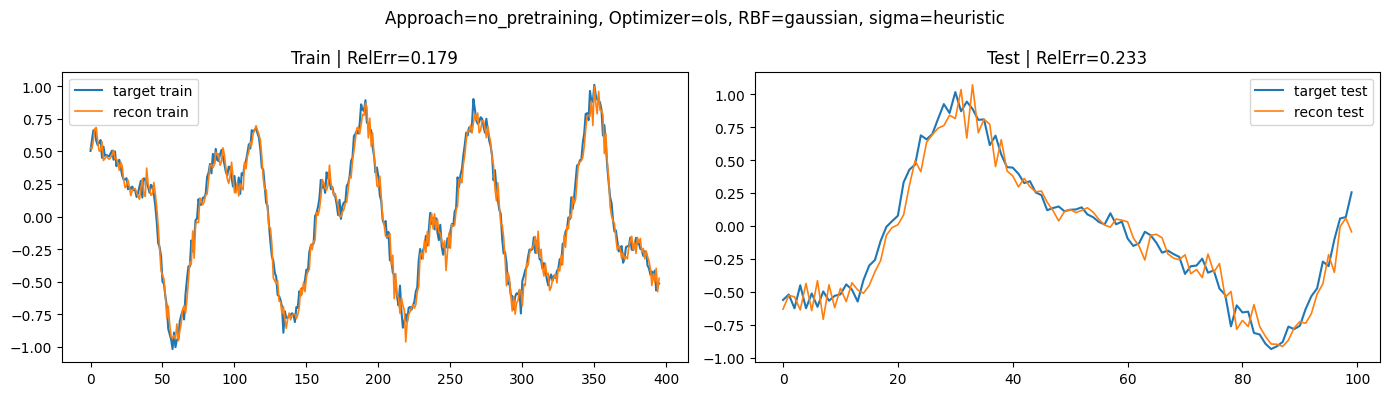

In [59]:
# Analyze reconstruction and visualize

def rel_err(a, b):
    a = a.reshape(-1)
    b = b.reshape(-1)
    return torch.linalg.norm(a - b) / (torch.linalg.norm(b) + 1e-12)

with torch.no_grad():
    y_hat_train = torch.zeros_like(d_train)
    y_hat_test = torch.zeros_like(d_test)
    if sel_idx.numel() > 0:
        y_hat_train = P_train[:, sel_idx] @ weights
        y_hat_test = P_test[:, sel_idx] @ weights

rerr_train = float(rel_err(y_hat_train, d_train))
rerr_test = float(rel_err(y_hat_test, d_test))
print(f"Relative error - train: {rerr_train:.4f} | test: {rerr_test:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=False)
axes[0].plot(d_train.numpy(), label="target train", lw=1.5)
axes[0].plot(y_hat_train.numpy(), label="recon train", lw=1.2)
axes[0].set_title(f"Train | RelErr={rerr_train:.3f}")
axes[0].legend()

axes[1].plot(d_test.numpy(), label="target test", lw=1.5)
axes[1].plot(y_hat_test.numpy(), label="recon test", lw=1.2)
axes[1].set_title(f"Test | RelErr={rerr_test:.3f}")
axes[1].legend()

plt.suptitle(f"Approach={cfg.approach}, Optimizer={cfg.optimizer}, RBF={cfg.rbf}, sigma={'heuristic' if cfg.sigma is None else cfg.sigma}")
plt.tight_layout()
plt.show()
